# 量的データ用（For quantitaive data）
[Methods]  
- Clustering methods : Kmeans, GMM, FSSEM, FSS-Kmeans    
- Allocation methods : random, proportional allocation, post stratification, optimal allocation

-------------
### ライブラリのインポート＆その他の設定（Importing Libraries & Other Settings）

In [1]:
# 基本的なライブラリ
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy import stats

# Scikit-learn関連
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils.validation import check_X_y

# 抽象基底クラス (ABC)
from abc import ABCMeta, abstractmethod

# タイピングのサポート
from typing import Optional

# シード設定
from lightning.pytorch import seed_everything

seed_everything(8)

# 可視化の設定
import matplotlib.pyplot as plt
import japanize_matplotlib

import itertools

plt.style.use("ggplot")

Seed set to 8


--------
### 実験設定

In [2]:
clusters = 3  # クラスタ数
n_features_to_select = 12  # 選択される最大の特徴量数

N_SAMPLES = 100  # 標本サイズ
data_size = 3000  # データサイズ(df2)
H = clusters  # 層の数
N_TRIALS = 1000  # 試行回数（標本平均を求める回数）
N_EXPERIMENT = 10  # 誤差分散を求める回数
m_VALUE = 2  # 各クラスタの最小標本数(最適標本配分)
RANDOM_STATE = 0  # 乱数シード
ALLOCATION_LIST = [
    "RandomAllocation",
    "ProportionalAllocation",
    "PostStratification",
    "OptimalAllocation",
]
CRITERION_LIST = ["ml"]  # ["ml", "tr", "none"]
CLUSTERING_METHOD_LIST = ["kmeans"]  # ["gmm", "kmeans"]

SELECTING_FEATURES = "not_all_features"  # "all_features" or "not_all_features" #特徴量を最大数選ぶかどうか

stratification_methods = list(itertools.product(CRITERION_LIST, CLUSTERING_METHOD_LIST))

-----------
### データの前処理（Data Preprocessing）

##### 外れ値を除去する関数

In [3]:
# 外れ値の除去
def remove_outliers_zscore(
    data: pd.DataFrame, metric: str, threshold: float = 2
) -> pd.DataFrame:
    z_scores = np.abs(stats.zscore(data[metric]))
    data = data[(z_scores < threshold)]
    return data

##### メルカリデータ（df1：全部, df2：一部）

In [4]:
# df1(all the data)
df1 = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\aug_first_cpn_data_for_ab_test_sensibility_tsukuba.csv"
)
obj1 = "GMV"
features_list1 = [
    "hist_4_day_buy_num",
    "hist_4_day_gmv",
    "his_4_day_is_buy",
    "hist_30_day_buy_days",
    "hist_30_day_buy_num",
    "hist_30_day_gmv",
    "hist_30_day_buy_recency",
    "hist_30_day_pay_days",
    "hist_30_day_atpu",
    "hist_30_day_gpv",
    "hist_30_day_pay_recency",
    "hist_30_day_list_days",
    "hist_30_day_list_num",
    "hist_30_day_list_recency",
    "hist_30_day_like_count",
    "hist_30_day_like_count_not_deleted",
    "hist_30_day_like_recency",
]

# df2(subset of the data)
df2 = df1.iloc[:data_size]
obj2 = obj1
features_list2 = features_list1

##### 外れ値除去と標準化

In [5]:
df = df2  # choose from (df1, df2)
obj = obj2  # choose from (obj1, obj2)
features_list = features_list1  # choose from (features_list1, features_list2)

# 外れ値除去
df = remove_outliers_zscore(df, obj)

# 標準化
X = df[features_list]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)
X_scaled = pd.DataFrame(scaled_features, columns=features_list)

# 目的変数
y = df[obj]

# 行を詰める
df = df.reset_index(drop=True)

-------------
### Wrapper法でクラスタリング

##### Wrapper Class

In [6]:
class Wrapper(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        n_features_to_select: int,
        n_clusters: int,
        criterion: str = "ml",
        clustering_method: str = "gmm",
        random_state: int = 0,
        selecting_features: str = "all_features",
    ):
        self.n_features_to_select = n_features_to_select  # 特徴量数
        self.n_clusters = n_clusters  # クラスタ数
        self.criterion = criterion  # 特徴量選択基準
        self.clustering_method = clustering_method  # クラスタリング手法
        self.random_state = random_state
        self.selecting_features = selecting_features

    def fss(self, X: pd.DataFrame, y: pd.DataFrame) -> "Wrapper":
        X, y = check_X_y(X, y)

        n_features = X.shape[1]  # 総特徴量数
        self.selected_features_ = []  # ここに選択した特徴量を入れる
        features_score_dict = {}  # 確認用

        # 選ばれた特徴量と残っている特徴量の初期化
        current_features = []
        remaining_features = list(range(n_features))
        if self.selecting_features == "not_all_features":
            best_score = -np.inf

        while len(current_features) < self.n_features_to_select:
            if self.selecting_features == "all_features":
                best_score = -np.inf
            best_feature = None  # 選ぶ特徴量の初期化

            for feature in remaining_features:
                temp_features = tuple(
                    current_features + [feature]
                )  # 特徴量をひとつ加え、score計算
                score = self.crit(X[:, temp_features])
                if score > best_score:
                    best_score = score
                    best_feature = feature

            if best_feature is not None:
                current_features.append(
                    best_feature
                )  # best feature をcurrent features に追加
                num_of_features = len(current_features)
                features_score = self.crit(X[:, current_features])
                print(
                    "num_of_features:",
                    num_of_features,
                    "current_features:",
                    current_features,
                    ", score:",
                    features_score,
                )

                features_score_dict[str(num_of_features)] = features_score  # 確認用

                remaining_features.remove(
                    best_feature
                )  # best feature をremaining features から取り除く
                self.selected_features_ = current_features
            else:
                break

        print("score using final features:", self.crit(X[:, :]))
        print("")

        # 選ばれた特徴量サブセットでクラスタリング
        final_features = X[:, self.selected_features_]
        if self.clustering_method == "gmm":
            self.final_model_ = GaussianMixture(
                n_components=self.n_clusters,
                random_state=self.random_state,
                init_params="kmeans",
            )
        elif self.clustering_method == "kmeans":
            self.final_model_ = KMeans(
                n_clusters=self.n_clusters, random_state=self.random_state
            )
        else:
            raise ValueError(f"Unknown clustering method: {self.clustering_method}")

        self.final_model_.fit(final_features)
        self.final_cluster_assignments_ = self.final_model_.predict(final_features)
        self.features_score_dict = features_score_dict  # 確認用

        return self

    def crit(self, X: pd.DataFrame) -> float:
        # クラスタリング手法がGMMの場合
        if self.clustering_method == "gmm":
            em = GaussianMixture(
                n_components=self.n_clusters,
                random_state=self.random_state,
                init_params="kmeans",
            )
            em.fit(X)
            labels = em.predict(X)

            if self.criterion == "tr":
                means = em.means_  # 平均ベクトル
                covariances = (
                    em.covariances_ + 1e-7
                )  # 共分散行列(各要素に微小な数が加算される)
                weights = em.weights_  # 混合比率
                overall_mean = np.sum(
                    weights[:, np.newaxis] * means, axis=0
                )  # 標本平均 #np.newaxisを使って1次元配列から2次元配列にする

                S_W = np.sum(weights[:, np.newaxis, np.newaxis] * covariances, axis=0)
                S_B = np.sum(
                    weights[:, np.newaxis, np.newaxis]
                    * np.einsum(
                        "...i,...j->...ij", means - overall_mean, means - overall_mean
                    ),
                    axis=0,
                )
                score = np.trace(np.linalg.solve(S_W, S_B))

            elif self.criterion == "ml":
                score = em.score(X)

        # クラスタリング手法がKMEANSの場合
        if self.clustering_method == "kmeans":
            kmeans = KMeans(
                n_clusters=self.n_clusters,
                random_state=self.random_state,
            )
            kmeans.fit(X)
            labels = kmeans.predict(X)

            if self.criterion == "tr":
                labels = kmeans.labels_
                cluster_centers = kmeans.cluster_centers_

                sw_i_list = []
                for i in range(self.n_clusters):
                    cluster_points = X[labels == i]

                    if cluster_points.shape[0] <= 2:
                        # データポイントが1つの場合はゼロ行列を使用
                        sw_i = np.zeros((X.shape[1], X.shape[1])) + 1e-7
                    else:
                        sw_i = (np.cov(cluster_points, rowvar=False) + 1e-7) * np.sum(
                            labels
                            == i  # データ数を重みに使う代わりにデータの割合を使う
                        )
                        if np.isscalar(sw_i):  # スカラー値のとき
                            sw_i = np.array([[sw_i]])
                    sw_i_list.append(sw_i)

                # 全クラスターの S_W を合計
                S_W = np.sum(sw_i_list, axis=0)

                # クラスター間散布行列 S_B を計算
                overall_mean = np.mean(X, axis=0)
                S_B = sum(
                    (np.sum(labels == i) / X.shape[0])  # 割合にする
                    * np.outer(
                        cluster_centers[i] - overall_mean,
                        cluster_centers[i] - overall_mean,
                    )
                    # *(cluster_centers[i] - overall_mean) @ (cluster_centers[i] - overall_mean).T
                    for i in range(self.n_clusters)
                )

                # 散乱分離性を計算
                score = np.trace(np.linalg.solve(S_W, S_B))

            elif self.criterion == "ml":
                score = -kmeans.score(X)

        return score

    def get_feature_index_out(self) -> NDArray:
        return np.array(self.selected_features_)  # 選択された特徴量のインデックス

    def get_final_cluster_assignments(self) -> NDArray:
        return self.final_cluster_assignments_  # 最終的なクラスタリング結果

    def get_features_score(self) -> dict:
        return self.features_score_dict

##### Wrapper classでクラスタリングしたとき

[ fsskmeans_ml ]


c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


num_of_features: 1 current_features: [15] , score: 830.9838300791038
num_of_features: 2 current_features: [15, 5] , score: 2787.744868347119
num_of_features: 3 current_features: [15, 5, 8] , score: 6434.265777493472
num_of_features: 4 current_features: [15, 5, 8, 12] , score: 8015.542615647322
num_of_features: 5 current_features: [15, 5, 8, 12, 0] , score: 10490.964396265028
num_of_features: 6 current_features: [15, 5, 8, 12, 0, 16] , score: 13374.351193538592
num_of_features: 7 current_features: [15, 5, 8, 12, 0, 16, 4] , score: 15866.82882954413
num_of_features: 8 current_features: [15, 5, 8, 12, 0, 16, 4, 13] , score: 18204.253935750407
num_of_features: 9 current_features: [15, 5, 8, 12, 0, 16, 4, 13, 6] , score: 19881.21598838748
num_of_features: 10 current_features: [15, 5, 8, 12, 0, 16, 4, 13, 6, 9] , score: 22864.628996919433
num_of_features: 11 current_features: [15, 5, 8, 12, 0, 16, 4, 13, 6, 9, 11] , score: 24715.396464929778
num_of_features: 12 current_features: [15, 5, 8, 1

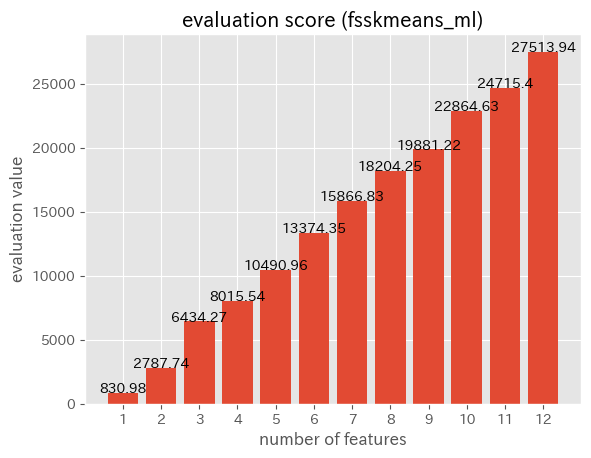

In [7]:
# Wrapper法を実装するための関数
def process_wrapper(
    name: str, instance: "Wrapper", X_scaled: pd.DataFrame, y: pd.DataFrame
):
    instance.fss(X_scaled, y)
    selected_features_index = instance.get_feature_index_out()
    cluster_label = instance.get_final_cluster_assignments()
    cluster_size = np.unique(cluster_label, return_counts=True)[1]
    features_score_dict = instance.get_features_score()

    return selected_features_index, cluster_label, cluster_size, features_score_dict


# Wrapperインスタンスのリスト
instances = []
if "gmm" in CLUSTERING_METHOD_LIST:
    if "tr" in CRITERION_LIST:
        instances.append(
            (
                "fssem_tr",
                Wrapper(
                    n_features_to_select=n_features_to_select,
                    n_clusters=clusters,
                    criterion="tr",
                    clustering_method="gmm",
                    random_state=0,
                    selecting_features=SELECTING_FEATURES,
                ),
            )
        )
    if "ml" in CRITERION_LIST:
        instances.append(
            (
                "fssem_ml",
                Wrapper(
                    n_features_to_select=n_features_to_select,
                    n_clusters=clusters,
                    criterion="ml",
                    clustering_method="gmm",
                    random_state=0,
                    selecting_features=SELECTING_FEATURES,
                ),
            )
        )
if "kmeans" in CLUSTERING_METHOD_LIST:
    if "tr" in CRITERION_LIST:
        instances.append(
            (
                "fsskmeans_tr",
                Wrapper(
                    n_features_to_select=n_features_to_select,
                    n_clusters=clusters,
                    criterion="tr",
                    clustering_method="kmeans",
                    random_state=0,
                    selecting_features=SELECTING_FEATURES,
                ),
            )
        )
    if "ml" in CRITERION_LIST:
        instances.append(
            (
                "fsskmeans_ml",
                Wrapper(
                    n_features_to_select=n_features_to_select,
                    n_clusters=clusters,
                    criterion="ml",
                    clustering_method="kmeans",
                    random_state=0,
                    selecting_features=SELECTING_FEATURES,
                ),
            )
        )


# 辞書の初期化
selected_features_index_dict = {}
cluster_label_dict = {}
cluster_size_dict = {}

# 各インスタンスに対して処理を実行
for name, instance in instances:
    print("[", name, "]")
    selected_features_index, cluster_label, cluster_size, features_score_dict = (
        process_wrapper(name, instance, X_scaled, y)
    )
    selected_features_index_dict[name] = selected_features_index
    cluster_label_dict[name] = cluster_label
    cluster_size_dict[name] = cluster_size
    print("選択された特徴量の数 : ", len(selected_features_index))
    print("選択された特徴量のインデックス : ", selected_features_index)
    print("各層のクラスタサイズ : ", cluster_size)
    # 棒グラフを作成

    plt.bar(features_score_dict.keys(), features_score_dict.values())
    for key, value in features_score_dict.items():
        rounded_value = round(value, 2)
        plt.text(key, value + 0.3, str(rounded_value), ha="center")
    plt.title(f"evaluation score ({name})")
    plt.xlabel("number of features")
    plt.ylabel("evaluation value")
    plt.show()

##### Kmeans, GMMでクラスタリングしたとき

In [8]:
clustering_methods = []
if "kmeans" in CLUSTERING_METHOD_LIST and "none" in CRITERION_LIST:
    clustering_methods.append("kmeans")
    kmeans = KMeans(n_clusters=clusters, random_state=0)
    kmeans_cluster = kmeans.fit_predict(X_scaled[:])
    kmeans_size = np.bincount(kmeans_cluster, minlength=clusters)
    cluster_label_dict["kmeans"] = kmeans_cluster
    cluster_size_dict["kmeans"] = kmeans_size

if "gmm" in CLUSTERING_METHOD_LIST and "none" in CRITERION_LIST:
    clustering_methods.append("gmm")
    gmm = GaussianMixture(n_components=clusters, random_state=0, init_params="kmeans")
    gmm_cluster = gmm.fit_predict(X_scaled)
    gmm_size = np.bincount(gmm_cluster, minlength=clusters)
    cluster_label_dict["gmm"] = gmm_cluster
    cluster_size_dict["gmm"] = gmm_size

for name in clustering_methods:
    print("[", name, "]")
    print("各層のクラスタサイズ : ", cluster_size_dict[name])
    print()

-----------------------------
### 標本配分（Allocation)

##### 基底クラス

In [9]:
class BaseAllocation(metaclass=ABCMeta):  # 抽象基底クラス（ABC）
    # 初期化クラス（n_samples(標本サイズ), H(クラスタ数)）
    def __init__(
        self,
        n_samples: int,
        H: int,
        random_state: int,
        criterion: str,
        clustering_method: str,
    ):
        self.n_samples = n_samples
        self.H = H
        self.random_state = random_state
        self.criterion = criterion
        self.clustering_method = clustering_method

    @abstractmethod
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """標本配分を解く

        Args:
            X (NDArray): データ (N x M)
            y (NDArray): 目的変数 (N)

        Raises:
            NotImplementedError: _description_

        Returns:
            NDArray: 各クラスタの標本数 (H, )

        Note:
            M: 特徴量数
            H: クラスタ数
        """
        # 具象クラスがsolveメゾッドを実装しない場合はNotImpleamentedErrorが発生
        raise NotImplementedError

    def clustering(self, X: NDArray) -> tuple[NDArray, NDArray]:
        if self.criterion == "tr" and self.clustering_method == "gmm":
            cluster_label = cluster_label_dict["fssem_tr"]
            cluster_size = cluster_size_dict["fssem_tr"]
        if self.criterion == "ml" and self.clustering_method == "gmm":
            cluster_label = cluster_label_dict["fssem_ml"]
            cluster_size = cluster_size_dict["fssem_ml"]
        if self.criterion == "tr" and self.clustering_method == "kmeans":
            cluster_label = cluster_label_dict["fsskmeans_tr"]
            cluster_size = cluster_size_dict["fsskmeans_tr"]
        if self.criterion == "ml" and self.clustering_method == "kmeans":
            cluster_label = cluster_label_dict["fsskmeans_ml"]
            cluster_size = cluster_size_dict["fsskmeans_ml"]
        if self.criterion == "none" and self.clustering_method == "kmeans":
            cluster_label = cluster_label_dict["kmeans"]
            cluster_size = cluster_size_dict["kmeans"]
        if self.criterion == "none" and self.clustering_method == "gmm":
            cluster_label = cluster_label_dict["gmm"]
            cluster_size = cluster_size_dict["gmm"]

        # インスタンス変数として設定
        self.cluster_label = cluster_label
        self.N = cluster_size
        return cluster_label, cluster_size

##### 単純無作為抽出のクラス

In [10]:
class RandomAllocation(BaseAllocation):
    # 抽象メゾッドを具象化
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """ランダムにn_samplesの標本を選択する"""
        n = np.array([self.n_samples])
        return n

    def clustering(self, X: NDArray) -> tuple[NDArray, NDArray]:
        # cluster_labelのすべての要素は0（すべてのデータを同じクラスタに属させている）
        cluster_label = np.zeros(
            X.shape[0]
        )  # cluster_label = [0,0,0,,...(要素数：データ数）]
        # クラスタサイズ＝データ数
        cluster_size = np.array([len(cluster_label)])  # cluster_size=[データ数]
        return cluster_label, cluster_size

##### 比例配分のクラス

In [11]:
class ProportionalAllocation(BaseAllocation):
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """各クラスタ数に比例した標本数で分割する"""
        n: NDArray = np.round(self.N / self.N.sum() * self.n_samples).astype(int)

        if n.sum() > self.n_samples:
            # nの合計がn_samplesより大きい場合は一番標本数が多いクラスタから削る
            n[np.argmax(n)] -= n.sum() - self.n_samples

        if n.sum() < self.n_samples:
            # nの合計がn_samplesより小さい場合は一番標本数が多いクラスタにたす
            n[np.argmax(n)] += -n.sum() + self.n_samples

        return n

##### 事後層化のクラス

In [12]:
class PostStratification(BaseAllocation):
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """ランダムにn_samplesの標本を選択する"""
        n = np.array([self.n_samples])

        return n  # （例）n=[標本サイズ]

##### 最適標本配分のクラス

In [25]:
class OptimalAllocation(BaseAllocation):
    def __init__(
        self,
        n_samples: int,
        H: int,
        m: NDArray,  # 標本サイズ下限
        M: Optional[NDArray] = None,  # 標本サイズ上限 #Optional(Noneである可能性がある)
        random_state: int = 0,
        criterion: str = "tr",
        clustering_method: str = "kmeans",
    ):
        super().__init__(
            n_samples, H, random_state, criterion, clustering_method
        )  # 基底クラスBaseAllocation（スーパークラス）の初期化メゾッドを呼び出す
        self.m = m  # 各クラスタの最小標本サイズ (H, )
        self.M = M  # 各クラスタの最大標本サイズ (H, ), (指定しない場合はクラスタサイズ)

    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        # S:クラスタ毎の目的変数のvarianceを要素とする配列 (H, )
        S = np.array([np.var(y[self.cluster_label == h]) for h in range(self.H)])
        print(S)
        print(self.N**2)
        print(self.N)
        d = (self.N**2) * S  # (H, )
        n = self._simple_greedy(n=self.m.copy(), d=d)

        # 制約チェック
        self._check_constraints(n)

        return n

    def _simple_greedy(self, n: NDArray, d: NDArray) -> NDArray:
        M = self.M.copy() if self.M is not None else self.N.copy()
        I = np.arange(self.H)  # noqa #クラスタのインデックス
        while (n.sum() != self.n_samples) and len(I) != 0:
            delta = np.zeros(self.H)
            delta[I] = (d / (n + 1) - d / n)[I]
            h_star = np.argmin(delta[I])
            h_star = I[h_star]

            if n[h_star] + 1 <= M[h_star]:
                n[h_star] = n[h_star] + 1
            else:
                # Iの要素h_starを削除
                I_ = I.tolist()
                I_ = [i for i in I_ if i != h_star]
                I = np.array(I_)  # noqa

        return n

    def _check_constraints(self, n: NDArray):
        assert (
            n.sum() <= self.n_samples
        ), f"Total sample size is over than {self.n_samples}"
        assert np.all(n >= self.m), "Minimum sample size constraint is not satisfied"
        if self.M is not None:
            assert np.all(
                n <= self.M
            ), "Maximum sample size constraint is not satisfied"

##### 母平均の推定値を計算する関数

In [26]:
def estimate_y_mean(n: NDArray, cluster_label: NDArray, y: NDArray) -> NDArray:
    """実際にサンプリングを行って目的変数の平均を推定

    Args:
        n (NDArray): 各クラスタの標本数 (H, )
        cluster_label (NDArray): クラスタラベル (N, )
        y (NDArray): 目的変数 (N, )

    Returns:
        NDArray: 推定された目的変数の平均

    Note:
        N: データ数
        H: クラスタ数
    """
    # cluster_labelからユニークなクラスタラベルを取得し、母集団の各クラスタのサイズNを取得
    N = np.unique(cluster_label, return_counts=True)[1]  # クラスタサイズ (H, )
    weights = N / N.sum()
    y_hat = 0
    for h in range(n.shape[0]):  # n.shape[0]:層の数
        if n[h] != 0:
            y_cluster = y[cluster_label == h]
            sample: NDArray = np.random.choice(y_cluster, n[h], replace=False)
            y_sample_mean = sample.mean()  # サンプリングした標本の平均
            y_hat += y_sample_mean * weights[h]

    return y_hat


def estimate_y_mean_post(n: NDArray, cluster_label: NDArray, y: NDArray) -> NDArray:
    N = np.unique(cluster_label, return_counts=True)[1]
    weights = N / N.sum()
    y_hat = 0
    indices = np.arange(N.sum())
    y_array = np.array(y.tolist())
    n_indices = np.random.choice(indices, n[0], replace=False)
    n_label = np.array([cluster_label[i] for i in n_indices])
    n_new_labels = np.unique(n_label)
    for h in n_new_labels:
        index = np.where(n_label == h)[0]
        sample = y_array[n_indices[index]]
        y_sample_mean = sample.mean()  # サンプリングした標本の平均
        y_hat += y_sample_mean * weights[h]
    return y_hat

##### 各ポリシーを生成

In [27]:
# 各ポリシーの生成を行う関数
def create_policies(
    criterion_list: list[str],
    clustering_method_list: list[str],
    n_samples: int,
    H: int,
    random_state: int,
    m_value: int,
):  # -> dict[list[str] : list[BaseAllocation]]:
    policies_dict = {}
    for criterion in criterion_list:
        for clustering_method in clustering_method_list:
            policies: list[BaseAllocation] = [
                RandomAllocation(
                    n_samples=n_samples,
                    H=H,
                    random_state=random_state,
                    criterion=criterion,
                    clustering_method=clustering_method,
                )
            ]
            if "ProportionalAllocation" in ALLOCATION_LIST:
                policies.append(
                    ProportionalAllocation(
                        n_samples=n_samples,
                        H=H,
                        random_state=random_state,
                        criterion=criterion,
                        clustering_method=clustering_method,
                    )
                )
            if "PostStratification" in ALLOCATION_LIST:
                policies.append(
                    PostStratification(
                        n_samples=n_samples,
                        H=H,
                        random_state=random_state,
                        criterion=criterion,
                        clustering_method=clustering_method,
                    )
                )
            if "OptimalAllocation" in ALLOCATION_LIST:
                policies.append(
                    OptimalAllocation(
                        n_samples=n_samples,
                        H=H,
                        random_state=random_state,
                        m=np.full(H, m_value),
                        M=None,
                        criterion=criterion,
                        clustering_method=clustering_method,
                    )
                )
            policies_dict[(criterion, clustering_method)] = policies
    return policies_dict

----------------
### 母平均の推定と分散の計算

##### 結果の出力

In [28]:
policies_dict = create_policies(
    CRITERION_LIST, CLUSTERING_METHOD_LIST, N_SAMPLES, H, RANDOM_STATE, m_VALUE
)

In [29]:
allocations_dict = {}
for method, policies in policies_dict.items():
    # それぞれの戦略で各クラスタの標本数を求解
    allocations: list[dict] = []  # 各戦略の実行結果が辞書形式で追加される
    for policy in policies:
        # policyを用いてXをクラスタリング
        cluster_label, _ = policy.clustering(X_scaled)
        n = policy.solve(X_scaled, y)
        allocations.append(
            {
                "policy": policy.__class__.__name__,
                "n": n,
                "cluster_label": cluster_label,
            }
        )
    allocations_dict[method] = allocations

[44551489.89776479  8504360.49456091 15162502.77064598]
[ 136900  630436 3225616]
[ 370  794 1796]


In [18]:
def cauculate_reduction_rate(
    X: pd.DataFrame, y: pd.DataFrame, policies_dict: dict
) -> dict:
    reduction_rate_dict = {}
    error_variance_dict = {}

    # 各戦略の標本数に基づいて目的変数の平均を推定
    y_hats_dict = {}
    for method, allocations in allocations_dict.items():
        y_hats = []
        for random_state in range(N_TRIALS):
            # print(random_state)
            for allocation in allocations:
                if allocation["policy"] == "PostStratification":
                    y_hat = estimate_y_mean_post(
                        allocation["n"], allocation["cluster_label"], y
                    )
                else:
                    y_hat = estimate_y_mean(
                        allocation["n"], allocation["cluster_label"], y
                    )
                y_hats.append(
                    {
                        "policy": allocation["policy"],
                        "y_hat": y_hat,
                        "random_state": random_state,
                    }
                )
        y_hats_dict[method] = y_hats

    for method, y_hats in y_hats_dict.items():
        y_hat_df = pd.DataFrame(y_hats)
        y_hat_df["error"] = (
            y_hat_df["y_hat"] - y.mean()
        )  # 真の平均からの誤差をerrorカラムに追加

        # random_allocationの誤差分散
        random_allocation_std = y_hat_df[y_hat_df["policy"] == "RandomAllocation"][
            "error"
        ].var()
        # random_allocation以外の誤差分散
        non_random_allocation_std = (
            y_hat_df[y_hat_df["policy"] != "RandomAllocation"]
            .groupby("policy")["error"]
            .var()
        )

        # 削減率
        reduction_rate = (1 - non_random_allocation_std / random_allocation_std) * 100

        ## policyの順番をpoliciesの順番に調整
        reduction_rate = reduction_rate.reindex(
            [policy.__class__.__name__ for policy in policies]
        )

        error_variance = pd.concat(
            [
                pd.Series(random_allocation_std, index=["RandomAllocation"]),
                non_random_allocation_std,
            ]
        )

        reduction_rate_dict[method] = reduction_rate
        error_variance_dict[method] = error_variance
    return reduction_rate_dict, error_variance_dict

In [19]:
all_reduction_rate = []
all_error_variance = []
for i in range(N_EXPERIMENT):
    reduction_rate_dict, error_variance_dict = cauculate_reduction_rate(
        X_scaled, y, policies_dict
    )
    all_reduction_rate.append(reduction_rate_dict)
    all_error_variance.append(error_variance_dict)

In [20]:
results_reduction_rate = {}
results_error_variance = {}
results_list = [results_reduction_rate, results_error_variance]
all_results = [all_reduction_rate, all_error_variance]

for i in range(2):
    for method in stratification_methods:
        results_list[i][method] = {}
        results_list[i][method]["RandomAllocation"] = []
        for allocation_method in ALLOCATION_LIST:
            results_list[i][method][allocation_method] = []

    for dict in all_results[i]:
        for method, policy in dict.items():
            for allocation_method in ALLOCATION_LIST:
                results_list[i][method][allocation_method].append(
                    policy[allocation_method]
                )

mean_results_reduction_rate = {}
mean_results_error_variance = {}
mean_results_list = [mean_results_reduction_rate, mean_results_error_variance]

for i in range(2):
    for method in stratification_methods:
        mean_results_list[i][method] = {}
        mean_results_list[i][method]["RandomAllocation"] = []
        for allocation_method in ALLOCATION_LIST:
            mean_results_list[i][method][allocation_method] = []

    for method, dict in results_list[i].items():
        for allocation_method in ALLOCATION_LIST:
            mean_results_list[i][method][allocation_method] = np.mean(
                np.array(dict[allocation_method])
            )

#####分散削減率の可視化

C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_22488\2403805569.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(allo_data, labels=allo_labels)


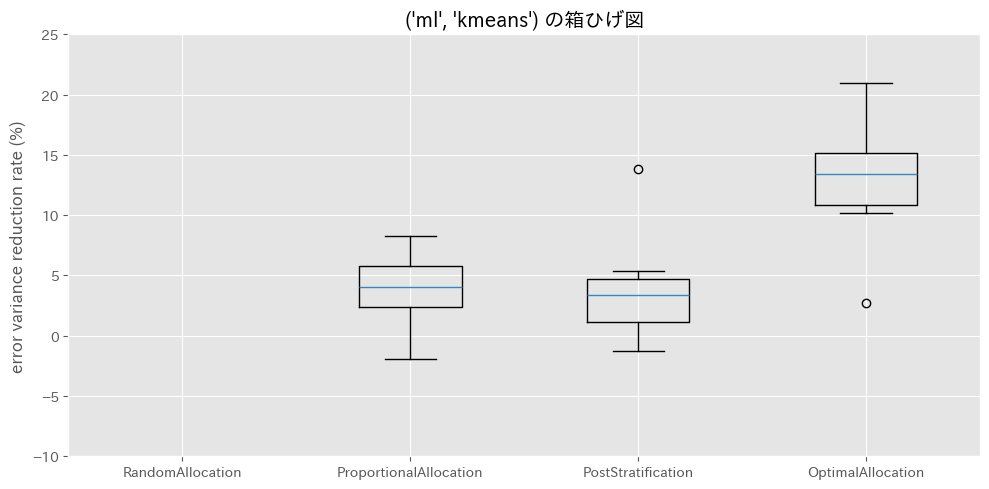

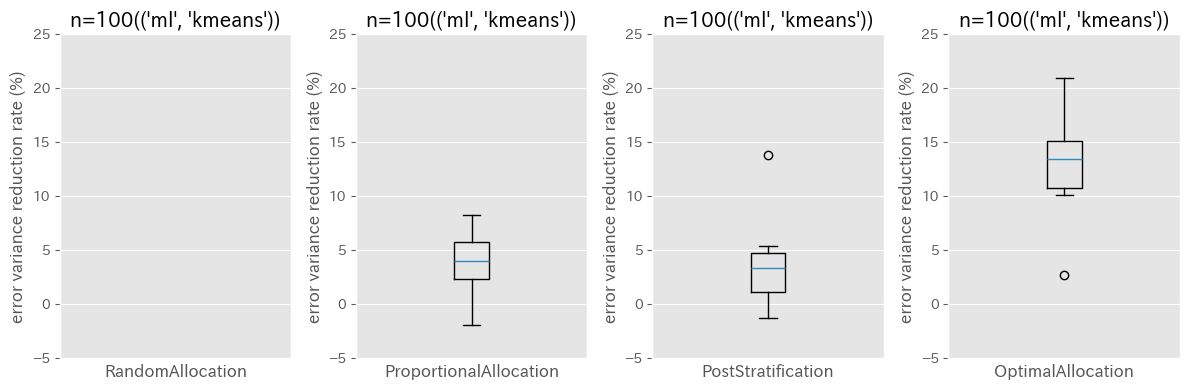

In [21]:
# グラフ作成
fig, axs = plt.subplots(
    1, len(results_reduction_rate), figsize=(10, 5)
)  # サブプロットを作成

# 各methodに対して
for i, (method, allocations) in enumerate(results_reduction_rate.items()):
    if isinstance(axs, np.ndarray):
        ax = axs[i]  # 複数サブプロットの場合
    else:
        ax = axs  # サブプロットが1つの場合はそのまま
    # ax = axs[i]  # i番目のサブプロット

    allo_data = list(allocations.values())  # allo1, allo2, allo3 のデータリスト
    allo_labels = list(allocations.keys())  # alloのラベルリスト
    # 箱ひげ図をプロット
    ax.boxplot(allo_data, labels=allo_labels)
    # グラフタイトルを設定
    ax.set_title(f"{method} の箱ひげ図")
    ax.set_ylabel("error variance reduction rate (%)")
    ax.set_ylim(-10, 25)
# グラフを表示
plt.tight_layout()  # レイアウトを調整
plt.show()


# グラフ作成
fig, axs = plt.subplots(
    len(CLUSTERING_METHOD_LIST), len(ALLOCATION_LIST), figsize=(12, 4)
)  # 2行3列のサブプロット作成
axs = axs.flatten()  # 2次元配列を1次元に平坦化して扱いやすくする

# ひとつづつのグラフ
plot_idx = 0  # サブプロットのインデックス
for method, allocations in results_reduction_rate.items():
    for allo_name, allo_data in allocations.items():
        ax = axs[plot_idx]  # 現在のサブプロットを取得
        ax.boxplot(allo_data)  # 箱ひげ図を描く
        ax.set_title(f"n={N_SAMPLES}({method})")  # タイトル設定
        ax.set_xlabel(allo_name)
        ax.set_xticks([])
        plot_idx += 1  # 次のサブプロットへ移動
        ax.set_ylabel("error variance reduction rate (%)")
        ax.set_ylim(-5, 25)
# レイアウト調整して表示
plt.rcParams["font.size"] = 10
plt.tight_layout()
plt.show()

posx and posy should be finite values
posx and posy should be finite values


[nan, 3.5138065273224894, 3.7005438424001604, 13.225014266299464]


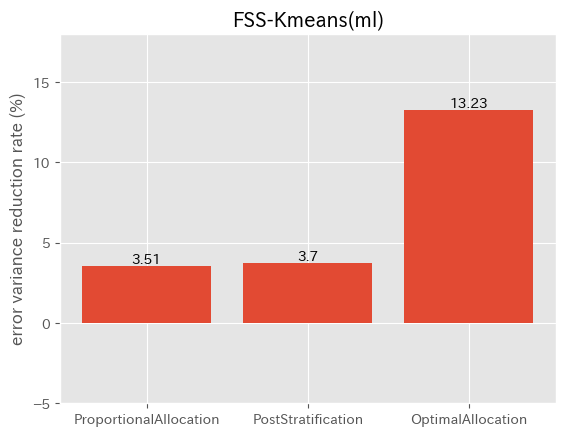

In [22]:
##################全部の結果の平均
title_list1 = [
    "比例配分の誤差分散削減率",
    "事後層化の誤差分散削減率",
    "最適標本配分の誤差分散削減率",
]

for method, dict in mean_results_reduction_rate.items():
    num = -1
    dict = mean_results_reduction_rate[method]
    # x = ["単純無作為抽出", "比例配分", "事後層化", "最適標本配分"]  # 横軸のラベル
    x = []
    for a in ALLOCATION_LIST:
        x.append(a)
    values = [val for val in dict.values()]
    print(values)
    plt.figure()  # 新しい図を作成
    bars = plt.bar(x, values)
    # 各バーの上に値を表示
    for bar in bars:
        yval = bar.get_height()  # 各バーの高さ（値）
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            round(yval, 2),
            ha="center",
            va="bottom",
        )  # 値をバーの上に表示

    # plt.ylabel("誤差分散削減率 (%)")
    plt.ylabel("error variance reduction rate (%)")
    plt.ylim(-5, 18)
    if method[0] == "none" and method[1] == "kmeans":
        plt.title("K-means")  # (number of clusters: {clusters})")
        plt.rcParams["font.size"] = 18
    if method[0] == "ml" and method[1] == "kmeans":
        plt.title("FSS-Kmeans(ml)")  # (number of clusters: {clusters})")
        plt.rcParams["font.size"] = 18
    if method[0] == "tr" and method[1] == "kmeans":
        plt.title(f"FSS-Kmeans-tr (number of clusters: {clusters})")
    if method[0] == "none" and method[1] == "gmm":
        plt.title(f"GMM (number of clusters: {clusters})")
    if method[0] == "ml" and method[1] == "gmm":
        plt.title(f"FSSEM-ml (number of clusters: {clusters})")
    if method[0] == "tr" and method[1] == "gmm":
        plt.title(f"FSSEM-tr (number of clusters: {clusters})")

    plt.show()

#####誤差分散の可視化

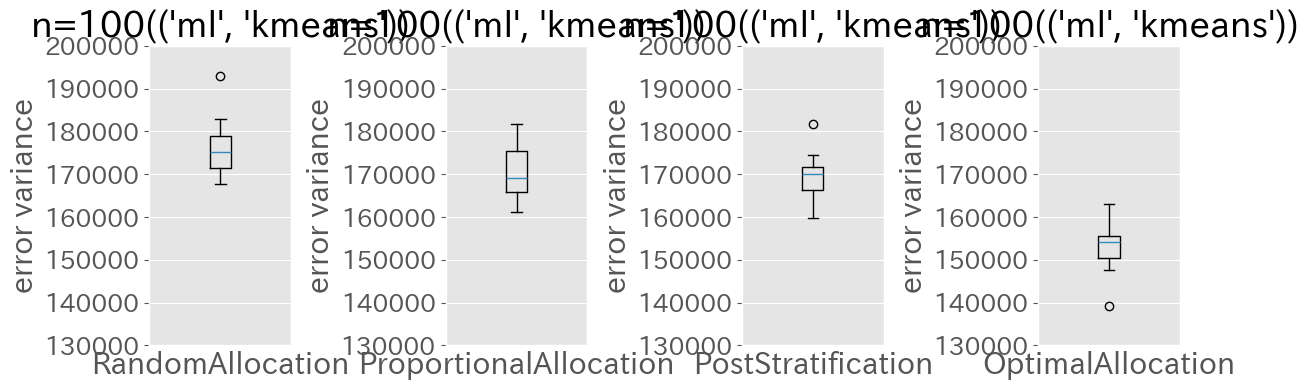

In [23]:
# グラフ作成
fig, axs = plt.subplots(
    len(CLUSTERING_METHOD_LIST), len(ALLOCATION_LIST), figsize=(12, 4)
)  # 2行3列のサブプロット作成
axs = axs.flatten()  # 2次元配列を1次元に平坦化して扱いやすくする

# ひとつづつのグラフ
plot_idx = 0  # サブプロットのインデックス
for method, allocations in results_error_variance.items():
    for allo_name, allo_data in allocations.items():
        ax = axs[plot_idx]  # 現在のサブプロットを取得
        ax.boxplot(allo_data)  # 箱ひげ図を描く
        ax.set_title(f"n={N_SAMPLES}({method})")  # タイトル設定
        ax.set_xlabel(allo_name)
        ax.set_xticks([])
        plot_idx += 1  # 次のサブプロットへ移動
        ax.set_ylabel("error variance")
        ax.set_ylim(130000, 200000)
# レイアウト調整して表示
plt.rcParams["font.size"] = 10
plt.tight_layout()
plt.show()

[176431.15392096827, 170136.9722716507, 169713.04137381312, 152866.86656036464]


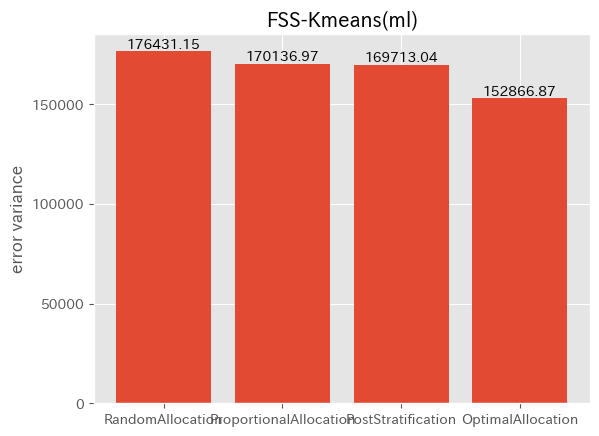

In [24]:
##################全部の結果の平均
title_list1 = [
    "比例配分の誤差分散削減率",
    "事後層化の誤差分散削減率",
    "最適標本配分の誤差分散削減率",
]

for method, dict in mean_results_error_variance.items():
    num = -1
    dict = mean_results_error_variance[method]
    # x = ["単純無作為抽出", "比例配分", "事後層化", "最適標本配分"]  # 横軸のラベル
    x = []
    for a in ALLOCATION_LIST:
        x.append(a)
    values = [val for val in dict.values()]
    print(values)
    plt.figure()  # 新しい図を作成
    bars = plt.bar(x, values)
    # 各バーの上に値を表示
    for bar in bars:
        yval = bar.get_height()  # 各バーの高さ（値）
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            round(yval, 2),
            ha="center",
            va="bottom",
        )  # 値をバーの上に表示

    # plt.ylabel("誤差分散削減率 (%)")
    plt.ylabel("error variance")
    # plt.ylim(-5, 18)
    if method[0] == "none" and method[1] == "kmeans":
        plt.title("K-means")  # (number of clusters: {clusters})")
        plt.rcParams["font.size"] = 18
    if method[0] == "ml" and method[1] == "kmeans":
        plt.title("FSS-Kmeans(ml)")  # (number of clusters: {clusters})")
        plt.rcParams["font.size"] = 18
    if method[0] == "tr" and method[1] == "kmeans":
        plt.title(f"FSS-Kmeans-tr (number of clusters: {clusters})")
    if method[0] == "none" and method[1] == "gmm":
        plt.title(f"GMM (number of clusters: {clusters})")
    if method[0] == "ml" and method[1] == "gmm":
        plt.title(f"FSSEM-ml (number of clusters: {clusters})")
    if method[0] == "tr" and method[1] == "gmm":
        plt.title(f"FSSEM-tr (number of clusters: {clusters})")

    plt.show()